In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import silhouette_score

Creation of Sythetic Data

In [ ]:
# Set seed for reproducibility
np.random.seed(42)

In [ ]:
# Generate base data
n = 1000

In [ ]:
df = pd.DataFrame()

df['ID'] = range(1, n+1)
df['Age'] = np.random.randint(5, 26, size=n)
df['Sex'] = np.random.choice(['Male', 'Female'], size=n, p=[0.5, 0.5])
df['Area'] = np.random.choice(['Urban', 'Rural'], size=n, p=[0.3, 0.7])
df['IncomeLevel'] = np.random.choice(['Poorest', 'Poor', 'Middle', 'Rich', 'Richest'],
                                       size=n,
                                       p=[0.25, 0.35, 0.25, 0.1, 0.05])

In [ ]:
# Literacy assignment
def assign_literacy(row):
    if row['IncomeLevel'] in ['Rich', 'Richest'] or row['Area'] == 'Urban':
        return np.random.choice(['Yes', 'No'], p=[0.9, 0.1])
    elif row['IncomeLevel'] == 'Middle':
        return np.random.choice(['Yes', 'No'], p=[0.75, 0.25])
    else:
        return np.random.choice(['Yes', 'No'], p=[0.6, 0.4])

In [ ]:
# ICT Access assignment
def assign_ict(row):
    if row['IncomeLevel'] in ['Rich', 'Richest'] and row['Area'] == 'Urban':
        return np.random.choice(['Yes', 'No'], p=[0.95, 0.05])
    elif row['IncomeLevel'] == 'Middle':
        return np.random.choice(['Yes', 'No'], p=[0.6, 0.4])
    else:
        if row['Sex'] == 'Female':
            return np.random.choice(['Yes', 'No'], p=[0.2, 0.8])
        else:
            return np.random.choice(['Yes', 'No'], p=[0.35, 0.65])

In [ ]:
# Education level assignment
def assign_edu(row):
    probs = {
        'Poorest':     [0.15, 0.5, 0.25, 0.08, 0.02],
        'Poor':        [0.1, 0.4, 0.3, 0.15, 0.05],
        'Middle':      [0.05, 0.25, 0.35, 0.25, 0.1],
        'Rich':        [0.01, 0.1, 0.3, 0.4, 0.19],
        'Richest':     [0.0, 0.05, 0.15, 0.45, 0.35]
    }
    return np.random.choice(
        ['None', 'Primary', 'Lower Secondary', 'Upper Secondary', 'Tertiary'],
        p=probs[row['IncomeLevel']]
    )

In [ ]:
# Dropout stage assignment
def assign_dropout(row):
    if row['EducationLevel'] == 'None':
        return 'After Primary'
    elif row['EducationLevel'] == 'Primary':
        return np.random.choice(['None', 'After Primary'], p=[0.4, 0.6])
    elif row['EducationLevel'] == 'Lower Secondary':
        return np.random.choice(['None', 'Lower Secondary'], p=[0.6, 0.4])
    elif row['EducationLevel'] == 'Upper Secondary':
        if row['Sex'] == 'Female':
            return np.random.choice(['None', 'Upper Secondary'], p=[0.7, 0.3])
        else:
            return np.random.choice(['None', 'Upper Secondary'], p=[0.9, 0.1])
    else:
        return 'None'

In [ ]:
# School infrastructure score assignment
def assign_infra_score(row):
    if row['Area'] == 'Urban':
        if row['IncomeLevel'] in ['Rich', 'Richest']:
            return np.random.randint(8, 11)
        elif row['IncomeLevel'] == 'Middle':
            return np.random.randint(6, 9)
        else:
            return np.random.randint(4, 7)
    else:  # Rural
        if row['IncomeLevel'] in ['Rich', 'Richest']:
            return np.random.randint(6, 9)
        elif row['IncomeLevel'] == 'Middle':
            return np.random.randint(3, 7)
        else:
            return np.random.randint(1, 5)

In [ ]:
# Province Assignment
def assign_province(row):

    provinces = [1, 2, 3, 4, 5, 6, 7]
    probs = [0.2, 0.1, 0.3, 0.1, 0.1, 0.1, 0.1]
    return np.random.choice(provinces, p=probs)

In [ ]:
# Apply all assignments
df['Literacy'] = df.apply(assign_literacy, axis=1)
df['ICTAccess'] = df.apply(assign_ict, axis=1)
df['EducationLevel'] = df.apply(assign_edu, axis=1)
df['DropoutStage'] = df.apply(assign_dropout, axis=1)
df['SchoolInfrastructureScore'] = df.apply(assign_infra_score, axis=1)
df['Province'] = df.apply(assign_province, axis=1)

Check Data

In [ ]:
df.sample(3)

,ID,Age,Sex,Area,IncomeLevel,Literacy,ICTAccess,EducationLevel,DropoutStage,SchoolInfrastructureScore,Province
718,719,21,Male,Urban,Middle,Yes,No,Lower Secondary,None,7,1
327,328,13,Female,Rural,Poorest,No,No,Primary,After Primary,3,7
638,639,22,Male,Rural,Rich,Yes,No,Lower Secondary,None,8,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         1000 non-null   int64 
 1   Age                        1000 non-null   int64 
 2   Sex                        1000 non-null   object
 3   Area                       1000 non-null   object
 4   IncomeLevel                1000 non-null   object
 5   Literacy                   1000 non-null   object
 6   ICTAccess                  1000 non-null   object
 7   EducationLevel             1000 non-null   object
 8   DropoutStage               1000 non-null   object
 9   SchoolInfrastructureScore  1000 non-null   int64 
 10  Province                   1000 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 86.1+ KB


Pre Process

In [ ]:
df['Sex'] = df['Sex'].astype('string')
df['Age'] = df['Age'].astype('int32')
df['IncomeLevel'] = df['IncomeLevel'].astype('string')
df['Area'] = df['Area'].astype('string')
df['Literacy'] = df['Literacy'].astype('string')
df['ICTAccess'] = df['ICTAccess'].astype('string')
df['EducationLevel'] = df['EducationLevel'].astype('string')
df['DropoutStage'] = df['DropoutStage'].astype('string')
df['SchoolInfrastructureScore'] = df['SchoolInfrastructureScore'].astype('int32')
df['Province'] = df['Province'].astype('int32')

# Check Data
df.sample(3)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         1000 non-null   int64 
 1   Age                        1000 non-null   int32 
 2   Sex                        1000 non-null   string
 3   Area                       1000 non-null   string
 4   IncomeLevel                1000 non-null   string
 5   Literacy                   1000 non-null   string
 6   ICTAccess                  1000 non-null   string
 7   EducationLevel             1000 non-null   string
 8   DropoutStage               1000 non-null   string
 9   SchoolInfrastructureScore  1000 non-null   int32 
 10  Province                   1000 non-null   int32 
dtypes: int32(3), int64(1), string(7)
memory usage: 74.3 KB


Visualizations

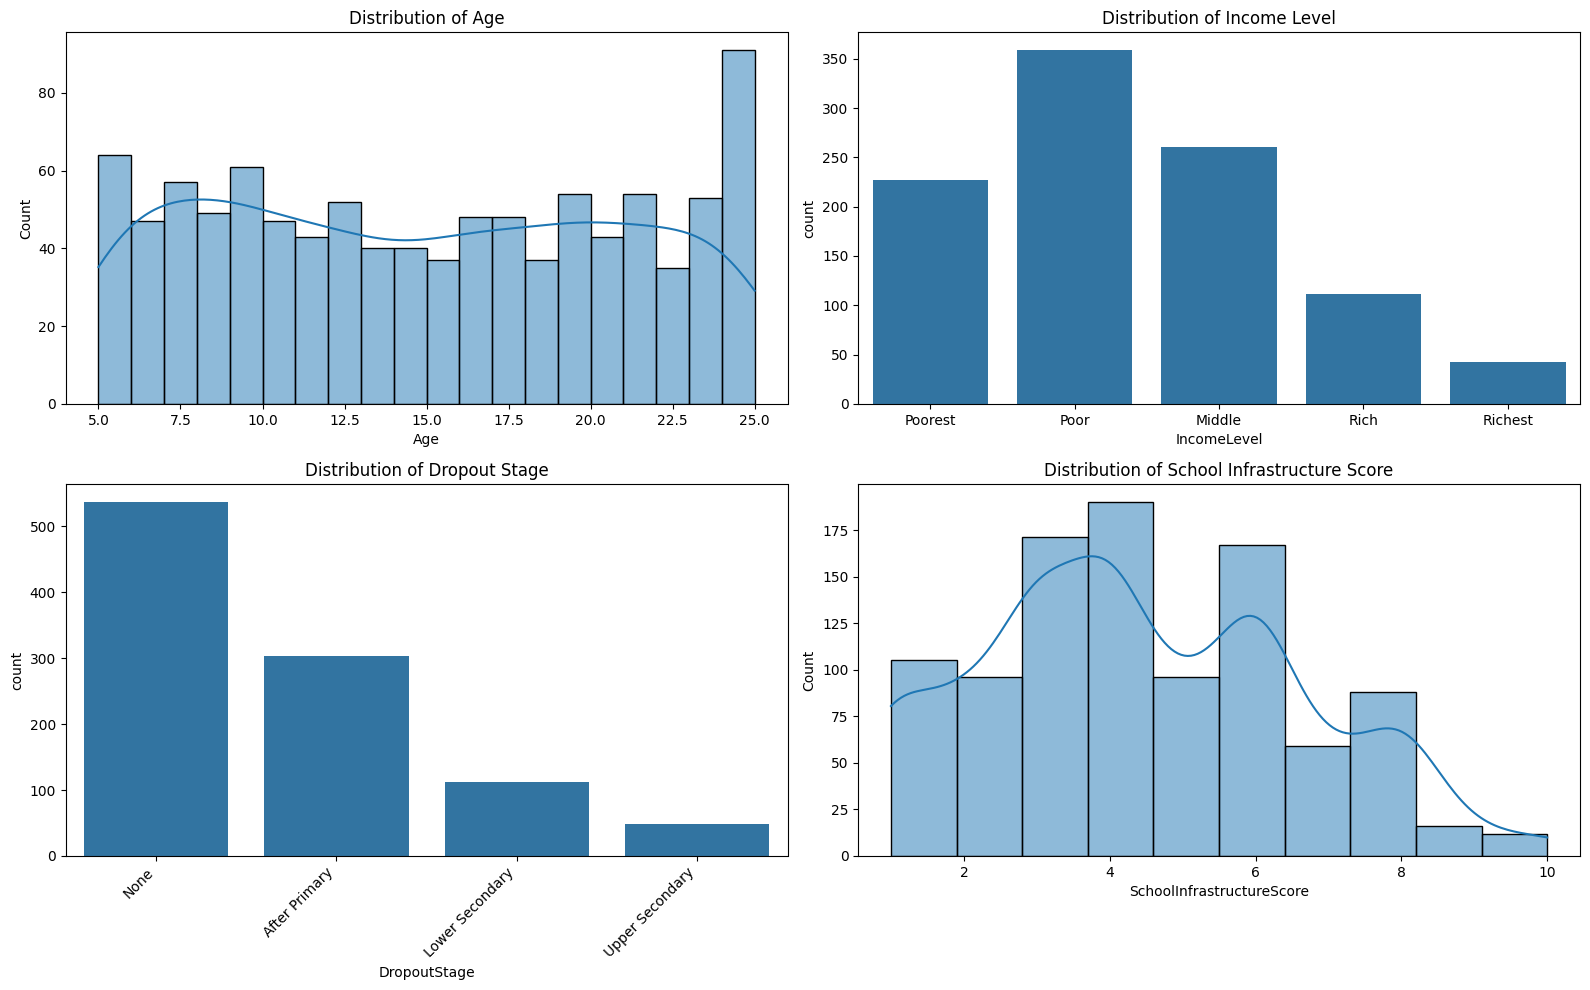

In [ ]:
# Visualize the distributions
plt.figure(figsize=(16, 10))

# Age Distribution
plt.subplot(2, 2, 1)
sns.histplot(df['Age'], kde=True, bins=20)
plt.title('Distribution of Age')

# IncomeLevel Distribution
plt.subplot(2, 2, 2)
sns.countplot(data=df, x='IncomeLevel', order=['Poorest', 'Poor', 'Middle', 'Rich', 'Richest'])
plt.title('Distribution of Income Level')

# DropoutStage Distribution
plt.subplot(2, 2, 3)
sns.countplot(data=df, x='DropoutStage')
plt.title('Distribution of Dropout Stage')
plt.xticks(rotation=45, ha='right')

# SchoolInfrastructureScore Distribution
plt.subplot(2, 2, 4)
sns.histplot(df['SchoolInfrastructureScore'], kde=True, bins=10)
plt.title('Distribution of School Infrastructure Score')

plt.tight_layout()
plt.show()

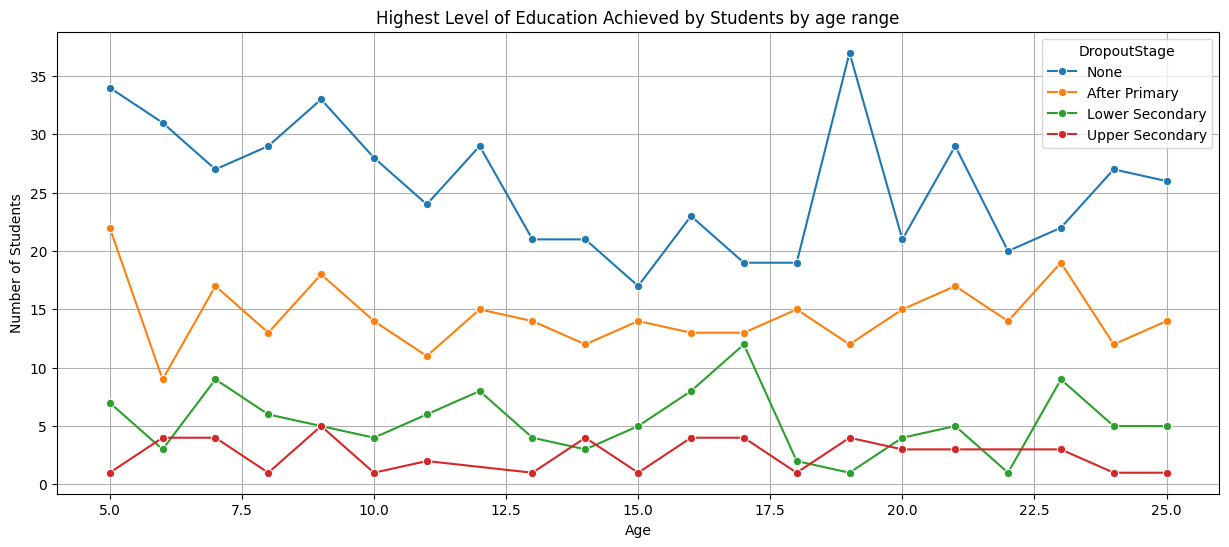

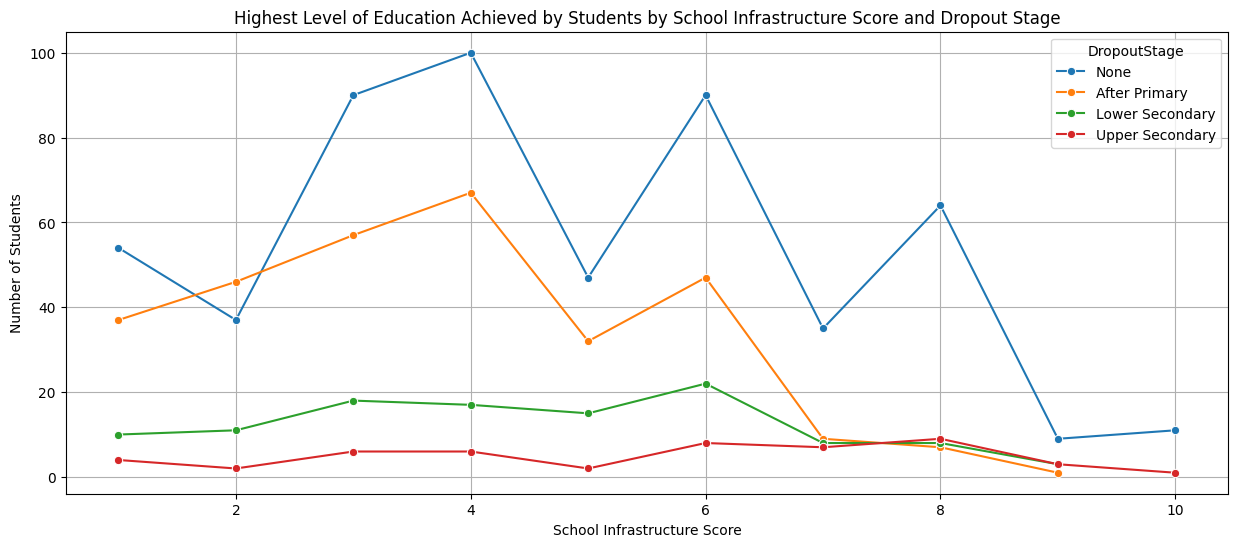

In [ ]:
# Group by 'DropoutStage' and 'Age', then count occurrences
dropout_age_counts = df.groupby(['DropoutStage', 'Age']).size().reset_index(name='count')

# Define the custom order for DropoutStage
dropout_order = ['None', 'After Primary', 'Lower Secondary', 'Upper Secondary']

# Convert 'DropoutStage' to a categorical type with the specified order
dropout_age_counts['DropoutStage'] = pd.Categorical(dropout_age_counts['DropoutStage'], categories=dropout_order, ordered=True)

# Sort by 'DropoutStage' and then 'Age'
dropout_age_counts = dropout_age_counts.sort_values(['DropoutStage', 'Age'])

# Plot the line graph
plt.figure(figsize=(15, 6))
sns.lineplot(data=dropout_age_counts, x='Age', y='count', hue='DropoutStage', marker='o')
plt.title('Highest Level of Education Achieved by Students by age range')
plt.xlabel('Age')
plt.ylabel('Number of Students')
plt.grid(True)
plt.show()

# Group by 'DropoutStage' and 'SchoolInfrastructureScore', then count occurrences
dropout_infra_counts = df.groupby(['DropoutStage', 'SchoolInfrastructureScore']).size().reset_index(name='count')

# Convert 'DropoutStage' to a categorical type with the specified order
dropout_infra_counts['DropoutStage'] = pd.Categorical(dropout_infra_counts['DropoutStage'], categories=dropout_order, ordered=True)

# Sort by 'DropoutStage' and then 'SchoolInfrastructureScore'
dropout_infra_counts = dropout_infra_counts.sort_values(['DropoutStage', 'SchoolInfrastructureScore'])

# Plot the line graph
plt.figure(figsize=(15, 6))
sns.lineplot(data=dropout_infra_counts, x='SchoolInfrastructureScore', y='count', hue='DropoutStage', marker='o')
plt.title('Highest Level of Education Achieved by Students by School Infrastructure Score and Dropout Stage')
plt.xlabel('School Infrastructure Score')
plt.ylabel('Number of Students')
plt.grid(True)
plt.show()

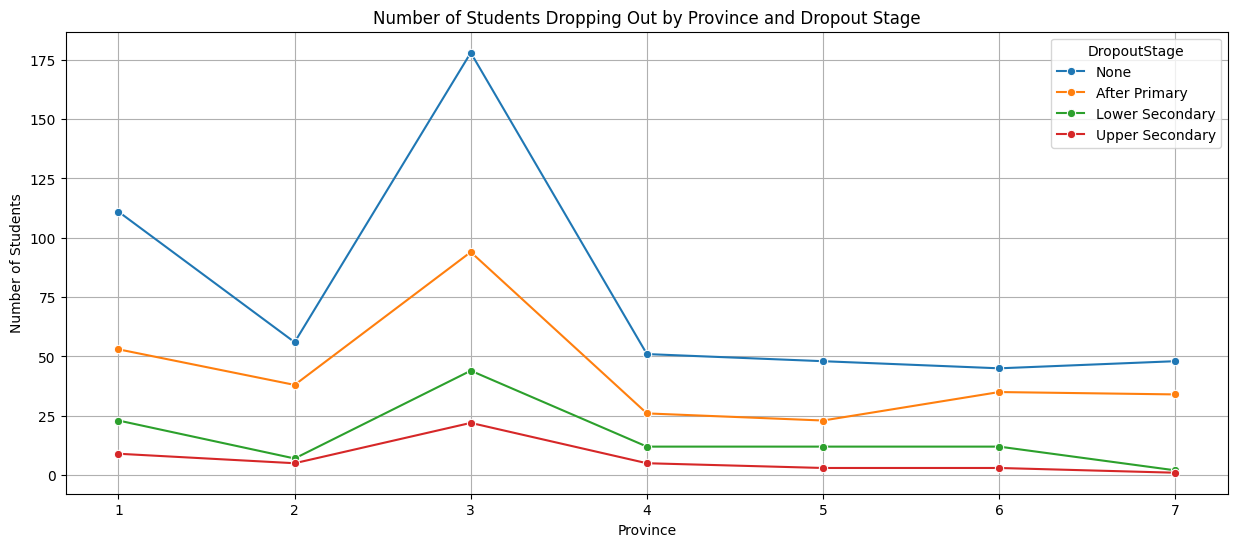

In [ ]:
# Group by 'Province' and 'DropoutStage', then count occurrences
dropout_province_counts = df.groupby(['Province', 'DropoutStage']).size().reset_index(name='count')

# Convert 'DropoutStage' to a categorical type with the specified order
dropout_province_counts['DropoutStage'] = pd.Categorical(dropout_province_counts['DropoutStage'], categories=dropout_order, ordered=True)

# Sort by 'Province' and then 'DropoutStage'
dropout_province_counts = dropout_province_counts.sort_values(['Province', 'DropoutStage'])

# Plot the line graph
plt.figure(figsize=(15, 6))
sns.lineplot(data=dropout_province_counts, x='Province', y='count', hue='DropoutStage', marker='o')
plt.title('Number of Students Dropping Out by Province and Dropout Stage')
plt.xlabel('Province')
plt.ylabel('Number of Students')
plt.xticks(dropout_province_counts['Province'].unique()) # Ensure all provinces are shown on x-axis
plt.grid(True)
plt.show()

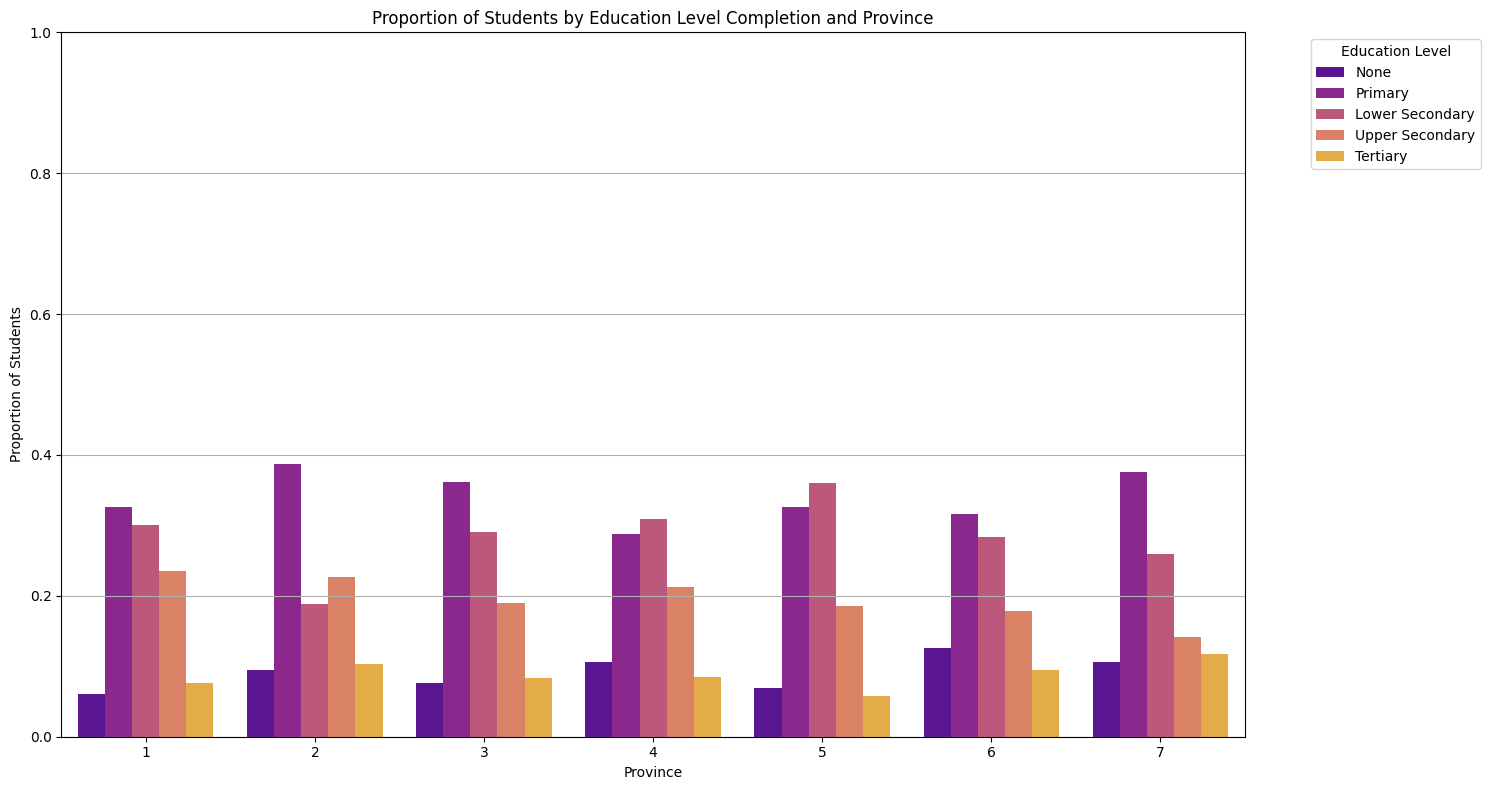

In [ ]:
# Calculate the number of students who completed each level of education
province_completion = df.groupby('Province')['EducationLevel'].value_counts(normalize=True).unstack(fill_value=0)

# Ensure all completion levels are present as columns
completion_levels = ['None', 'Primary', 'Lower Secondary', 'Upper Secondary', 'Tertiary']
for level in completion_levels:
    if level not in province_completion.columns:
        province_completion[level] = 0

# Select only the completion rate columns
province_completion_rates = province_completion[completion_levels]

# Reset index to make Province a column again
province_completion_rates = province_completion_rates.reset_index()

# Melt the dataframe for plotting
province_completion_rates_melted = province_completion_rates.melt(
    id_vars='Province',
    value_vars=completion_levels,
    var_name='Education Level',
    value_name='Proportion'
)

# Visualize the stacked bar chart
plt.figure(figsize=(15, 8))
sns.barplot(data=province_completion_rates_melted, x='Province', y='Proportion', hue='Education Level', palette='plasma')
plt.title('Proportion of Students by Education Level Completion and Province')
plt.xlabel('Province')
plt.ylabel('Proportion of Students')
plt.ylim(0, 1)
plt.legend(title='Education Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

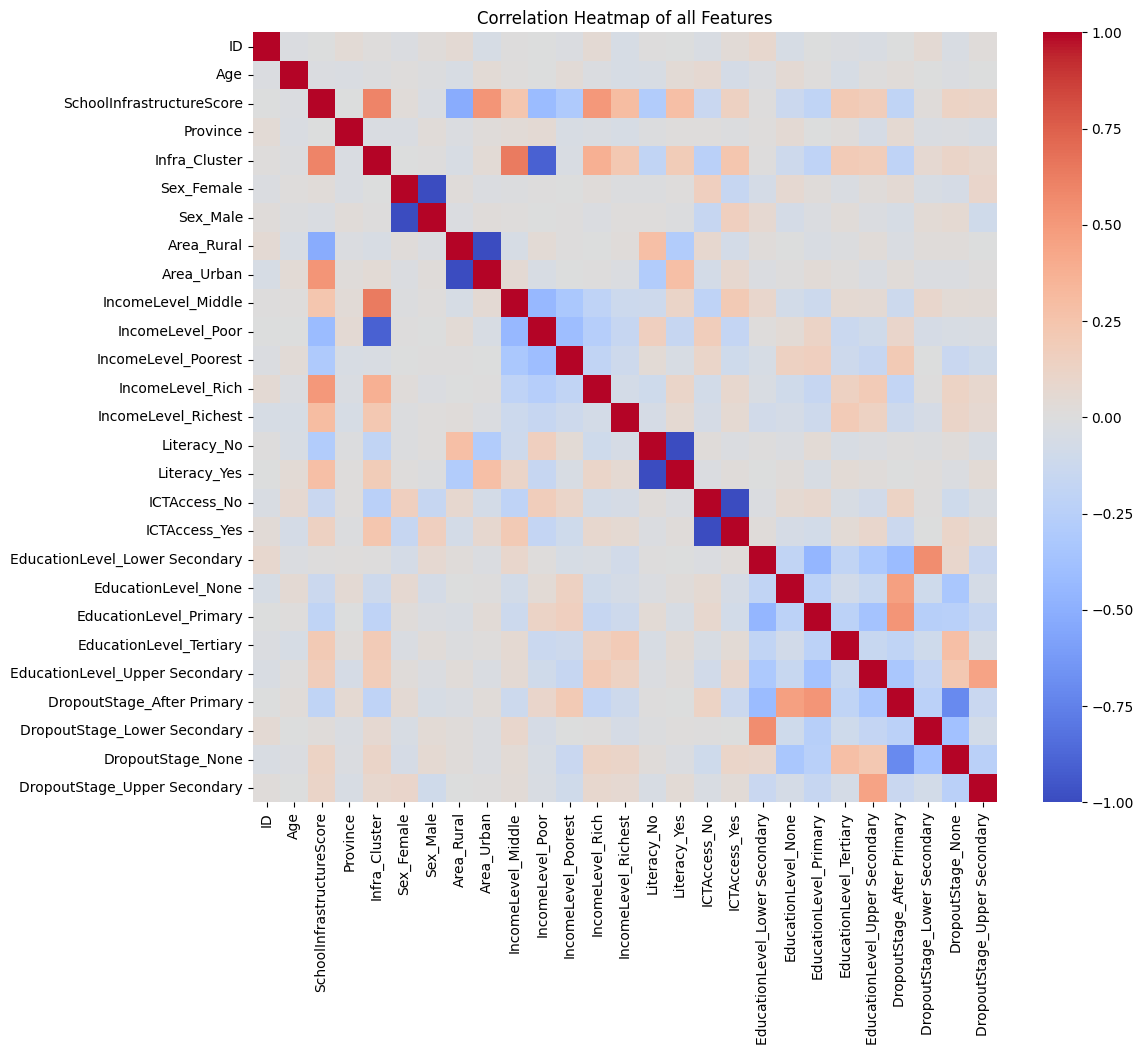

In [ ]:
# One-Hot Encode categorical features
df_encoded = pd.get_dummies(df, columns=['Sex', 'Area', 'IncomeLevel', 'Literacy', 'ICTAccess', 'EducationLevel', 'DropoutStage'])

# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False) # annot=False to avoid clutter with many columns
plt.title('Correlation Heatmap of all Features')
plt.show()

Machine Learning Models

In [ ]:
target_col = 'DropoutStage'
X = df.drop(columns=[target_col])
# X = df[['parent_edu_level','attendance_rate','avg_score', 'household_income','gender','school_infrastructure_score']]
y = df[target_col]

# Convert categorical columns if needed
X = pd.get_dummies(X, drop_first=True)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
# Train logistic regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Predict on test set
y_pred = log_model.predict(X_test)

# Accuracy and F1 Score
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted') # Using weighted average for multiclass

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7033
F1 Score: 0.6674

Classification Report:
                  precision    recall  f1-score   support

  After Primary       0.77      0.93      0.84       107
Lower Secondary       0.44      0.11      0.18        35
           None       0.68      0.73      0.70       145
Upper Secondary       0.20      0.08      0.11        13

       accuracy                           0.70       300
      macro avg       0.52      0.46      0.46       300
   weighted avg       0.66      0.70      0.67       300



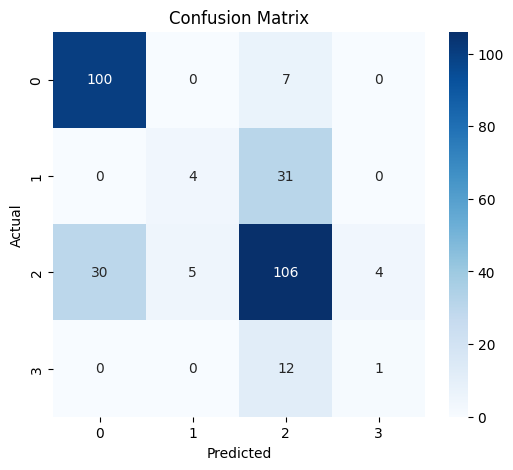

In [ ]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Select relevant features
infra_features = ['SchoolInfrastructureScore', 'IncomeLevel']
infra_df = df[infra_features].copy()

In [ ]:
# Preprocesss the data
infra_df_encoded = pd.get_dummies(infra_df, columns=['IncomeLevel'], drop_first=True)
scaler = StandardScaler()
infra_scaled = scaler.fit_transform(infra_df_encoded)

In [ ]:
from sklearn.cluster import KMeans

# Try 3 segments for example: Low, Medium, High infrastructure
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(infra_scaled)

# Add cluster label to the original dataframe
df['Infra_Cluster'] = clusters

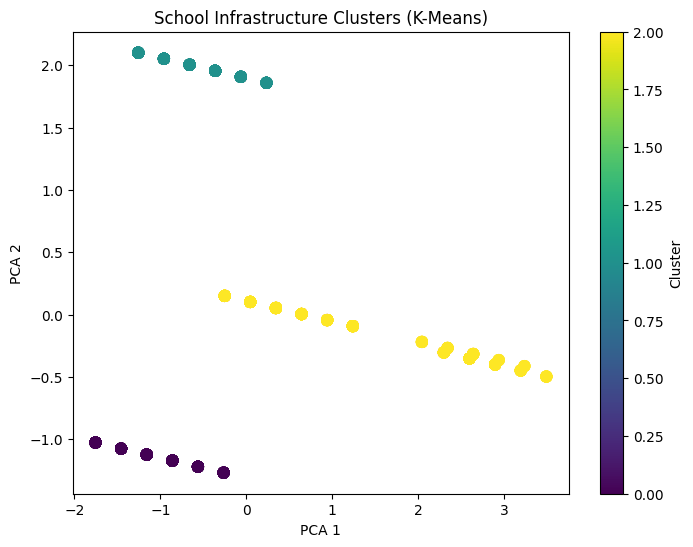

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(infra_scaled)

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c=clusters, cmap='viridis', s=60)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('School Infrastructure Clusters (K-Means)')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
sil_score = silhouette_score(infra_scaled, clusters)
print(f"Silhouette Score for Infrastructure Clusters: {sil_score:.4f}")

Silhouette Score for Infrastructure Clusters: 0.5358


KPIs

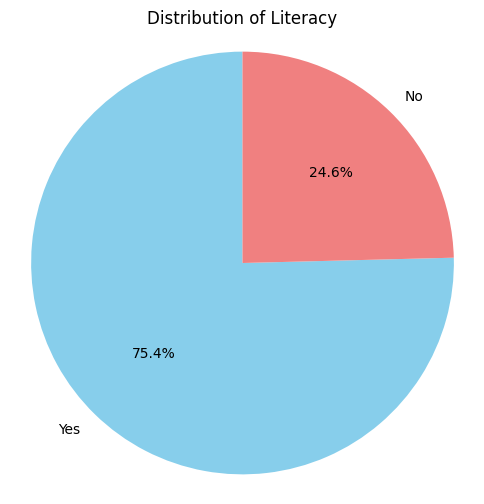

In [ ]:
literacy_counts = df['Literacy'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(literacy_counts, labels=literacy_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Literacy')
plt.axis('equal')
plt.show()

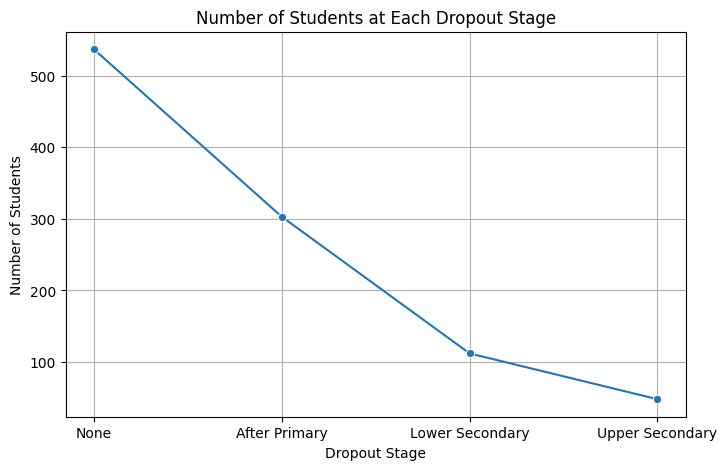

In [ ]:
# Calculate the number of students at each dropout stage
dropout_stage_counts = df['DropoutStage'].value_counts().reset_index()
dropout_stage_counts.columns = ['DropoutStage', 'Count']

# Define the custom order for DropoutStage
dropout_order = ['None', 'After Primary', 'Lower Secondary', 'Upper Secondary']

# Convert 'DropoutStage' to a categorical type with the specified order
dropout_stage_counts['DropoutStage'] = pd.Categorical(dropout_stage_counts['DropoutStage'], categories=dropout_order, ordered=True)

# Sort by the specified order
dropout_stage_counts = dropout_stage_counts.sort_values('DropoutStage')

# Plot the line chart
plt.figure(figsize=(8, 5))
sns.lineplot(data=dropout_stage_counts, x='DropoutStage', y='Count', marker='o')
plt.title('Number of Students at Each Dropout Stage')
plt.xlabel('Dropout Stage')
plt.ylabel('Number of Students')
plt.grid(True)
plt.show()

/tmp/ipython-input-105-4026055986.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=edu_income, x='EducationLevel', y='IncomeScore', palette='viridis')


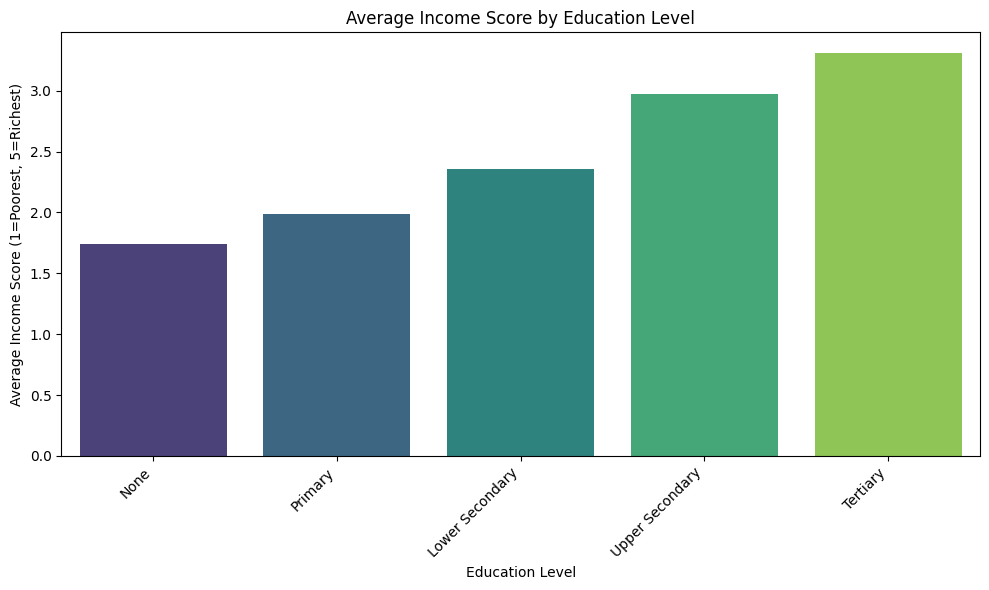

In [ ]:
# Map IncomeLevel to numerical values for plotting purposes (Rich = higher value)
income_mapping = {'Poorest': 1, 'Poor': 2, 'Middle': 3, 'Rich': 4, 'Richest': 5}
df_temp = df.copy()
df_temp['IncomeScore'] = df_temp['IncomeLevel'].map(income_mapping)

# Group by EducationLevel and calculate the mean IncomeScore
edu_income = df_temp.groupby('EducationLevel')['IncomeScore'].mean().reset_index()

# Define the custom order for EducationLevel
education_order = ['None', 'Primary', 'Lower Secondary', 'Upper Secondary', 'Tertiary']

# Convert 'EducationLevel' to a categorical type with the specified order
edu_income['EducationLevel'] = pd.Categorical(edu_income['EducationLevel'], categories=education_order, ordered=True)

# Sort by the specified order
edu_income = edu_income.sort_values('EducationLevel')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=edu_income, x='EducationLevel', y='IncomeScore', palette='viridis')
plt.title('Average Income Score by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Average Income Score (1=Poorest, 5=Richest)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-106-826064711.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ict_access_yes, x='EducationLevel', y='percentage', palette='viridis')


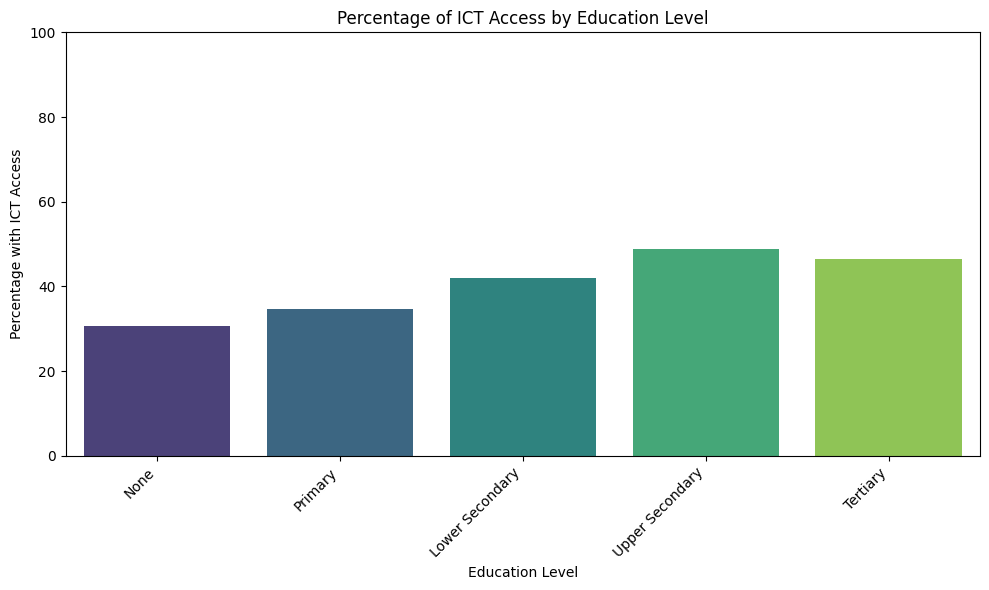

In [ ]:
ict_edu_counts = df.groupby(['EducationLevel', 'ICTAccess']).size().reset_index(name='count')

# Define the custom order for EducationLevel
education_order = ['None', 'Primary', 'Lower Secondary', 'Upper Secondary', 'Tertiary']

# Convert 'EducationLevel' to a categorical type with the specified order
ict_edu_counts['EducationLevel'] = pd.Categorical(ict_edu_counts['EducationLevel'], categories=education_order, ordered=True)

# Sort by 'EducationLevel' and then 'ICTAccess'
ict_edu_counts = ict_edu_counts.sort_values(['EducationLevel', 'ICTAccess'])

# Filter for 'Yes' in ICTAccess for easier plotting of access percentage
ict_access_yes = ict_edu_counts[ict_edu_counts['ICTAccess'] == 'Yes'].copy()

# Calculate total count for each education level
total_edu_counts = df['EducationLevel'].value_counts().reset_index()
total_edu_counts.columns = ['EducationLevel', 'total_count']

# Convert 'EducationLevel' to categorical for sorting
total_edu_counts['EducationLevel'] = pd.Categorical(total_edu_counts['EducationLevel'], categories=education_order, ordered=True)
total_edu_counts = total_edu_counts.sort_values('EducationLevel')

# Merge to get total counts per education level
ict_access_yes = pd.merge(ict_access_yes, total_edu_counts, on='EducationLevel')

# Calculate the percentage of ICT access per education level
ict_access_yes['percentage'] = (ict_access_yes['count'] / ict_access_yes['total_count']) * 100

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=ict_access_yes, x='EducationLevel', y='percentage', palette='viridis')
plt.title('Percentage of ICT Access by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage with ICT Access')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

/tmp/ipython-input-107-3653782236.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=completion_df, x='EducationLevel', y='CompletionRate', palette='viridis')


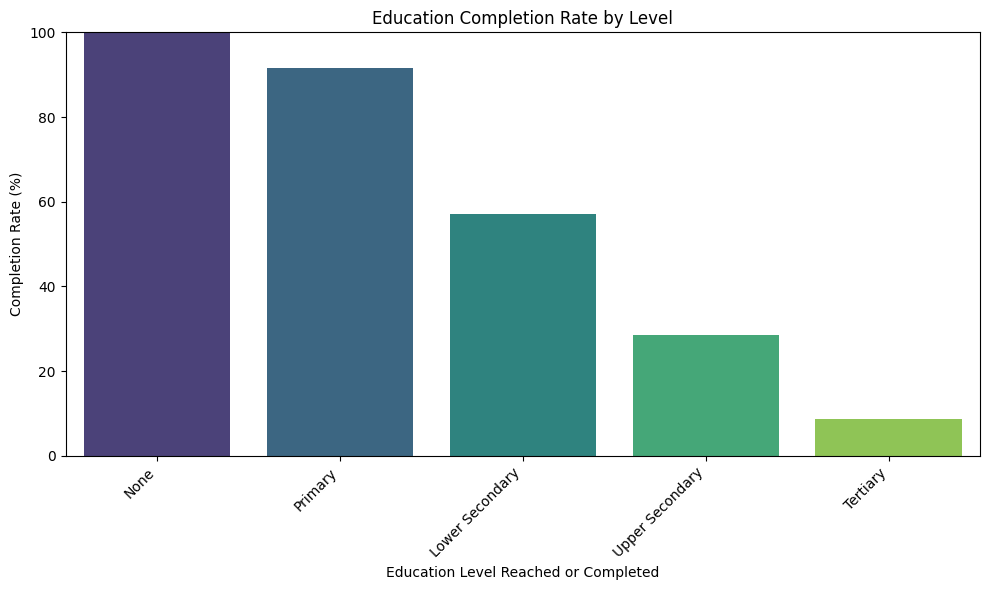

In [ ]:
# Define the education levels in hierarchical order
education_levels_order = ['None', 'Primary', 'Lower Secondary', 'Upper Secondary', 'Tertiary']

# Calculate total students (or total in the dataset)
total_students = len(df)

completion_counts = {}
for i, level in enumerate(education_levels_order):
    completed_or_above = education_levels_order[i:]
    count = df[df['EducationLevel'].isin(completed_or_above)].shape[0]
    completion_counts[level] = count

# Convert counts to completion rates
completion_rates = {level: (count / total_students) * 100 for level, count in completion_counts.items()}

# Convert to a DataFrame for plotting
completion_df = pd.DataFrame(list(completion_rates.items()), columns=['EducationLevel', 'CompletionRate'])

# Ensure the order of levels is correct for plotting
completion_df['EducationLevel'] = pd.Categorical(completion_df['EducationLevel'], categories=education_levels_order, ordered=True)
completion_df = completion_df.sort_values('EducationLevel')

# Plotting the completion rates
plt.figure(figsize=(10, 6))
sns.barplot(data=completion_df, x='EducationLevel', y='CompletionRate', palette='viridis')
plt.title('Education Completion Rate by Level')
plt.xlabel('Education Level Reached or Completed')
plt.ylabel('Completion Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

/tmp/ipython-input-108-351335928.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ict_access_yes, x='EducationLevel', y='percentage', palette='viridis')
/tmp/ipython-input-108-351335928.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=completion_df, x='EducationLevel', y='CompletionRate', palette='viridis')
/tmp/ipython-input-108-351335928.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=edu_income, x='EducationLevel', y='IncomeScore', palette='viridis')


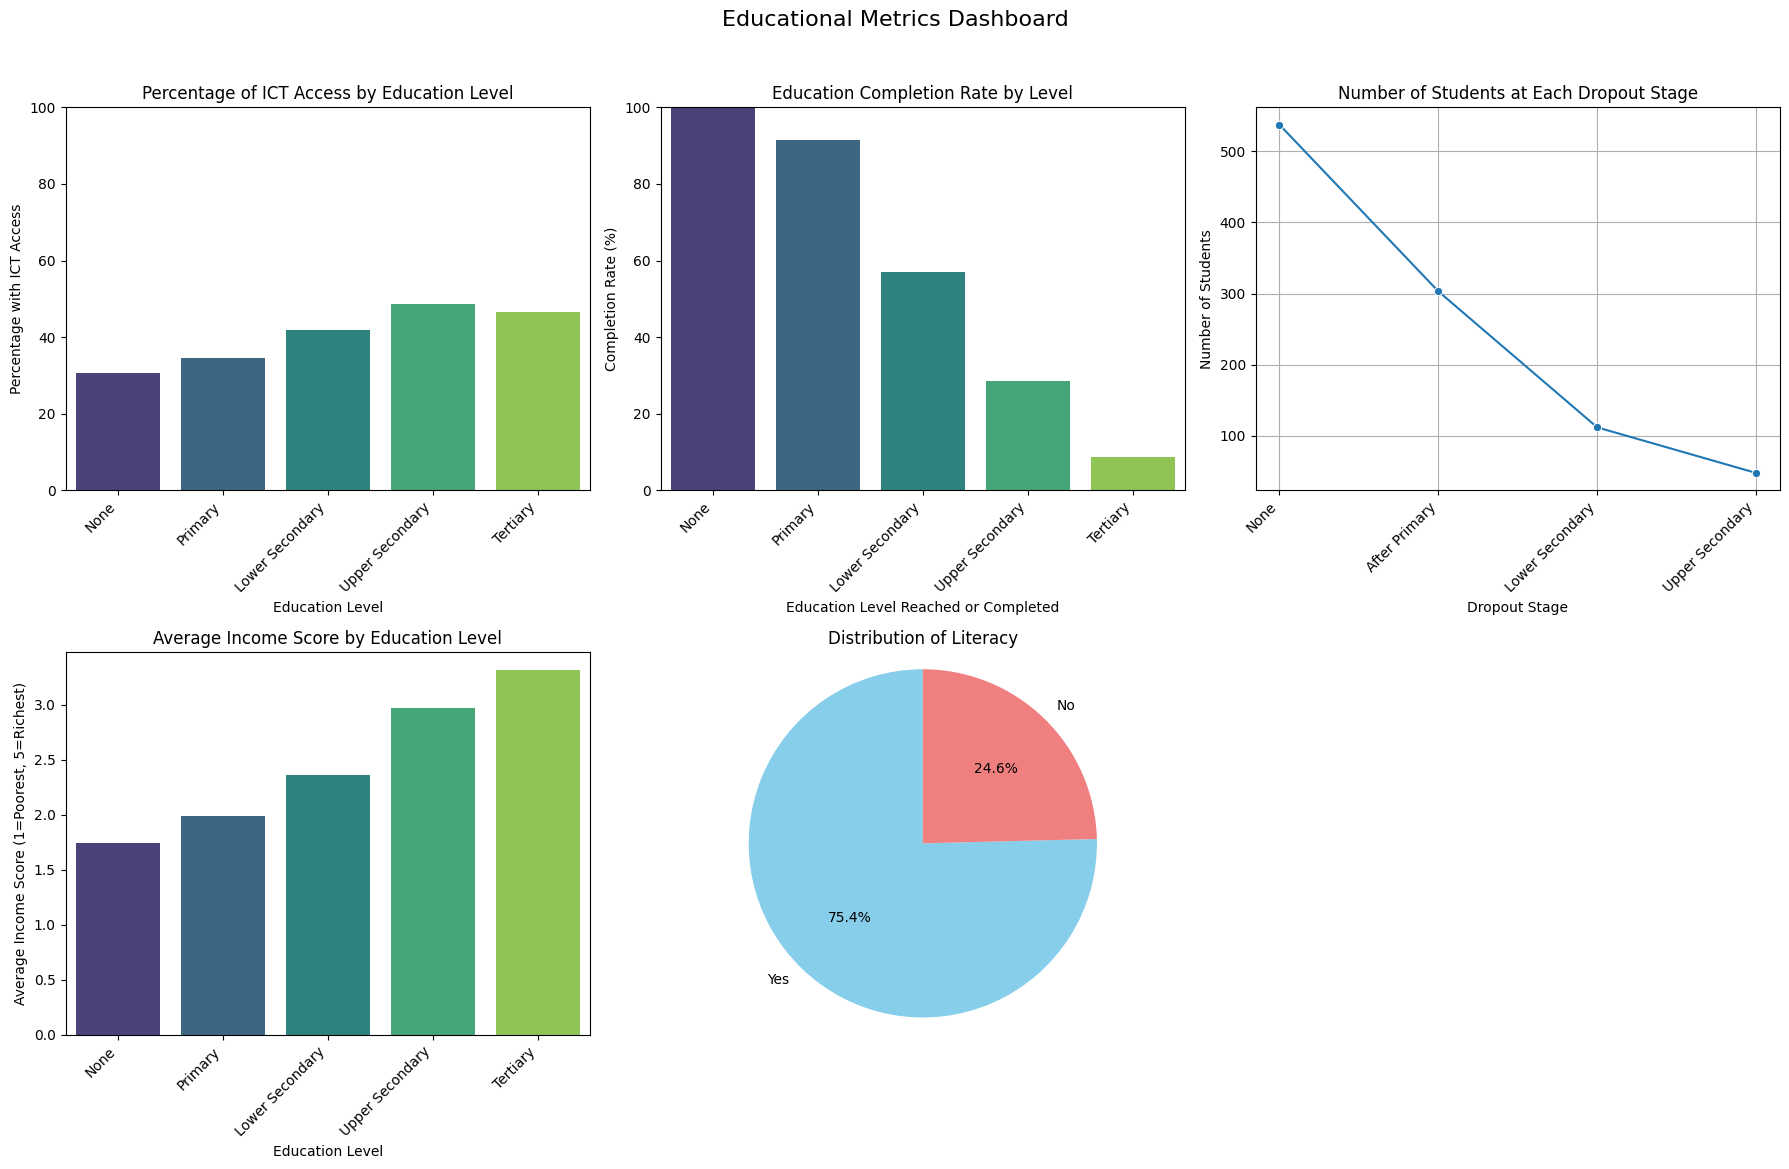

In [ ]:
plt.figure(figsize=(18, 12))

# Chart 1: ICT Access by Education Level
plt.subplot(2, 3, 1)
sns.barplot(data=ict_access_yes, x='EducationLevel', y='percentage', palette='viridis')
plt.title('Percentage of ICT Access by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage with ICT Access')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)

# Chart 2: Education Completion Rate by Level
plt.subplot(2, 3, 2)
sns.barplot(data=completion_df, x='EducationLevel', y='CompletionRate', palette='viridis')
plt.title('Education Completion Rate by Level')
plt.xlabel('Education Level Reached or Completed')
plt.ylabel('Completion Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)

# Chart 3: Number of Students at Each Dropout Stage
plt.subplot(2, 3, 3)
sns.lineplot(data=dropout_stage_counts, x='DropoutStage', y='Count', marker='o')
plt.title('Number of Students at Each Dropout Stage')
plt.xlabel('Dropout Stage')
plt.ylabel('Number of Students')
plt.grid(True)
plt.xticks(rotation=45, ha='right')

# Chart 4: Average Income Score by Education Level
plt.subplot(2, 3, 4)
sns.barplot(data=edu_income, x='EducationLevel', y='IncomeScore', palette='viridis')
plt.title('Average Income Score by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Average Income Score (1=Poorest, 5=Richest)')
plt.xticks(rotation=45, ha='right')

# Chart 5: Literacy Distribution (from previous code)
plt.subplot(2, 3, 5)
plt.pie(literacy_counts, labels=literacy_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Literacy')
plt.axis('equal')


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for a potential suptitle
plt.suptitle('Educational Metrics Dashboard', fontsize=16, y=1.0) # Add a main title
plt.show()